# Dynamic Time Warping for Speech Recognition
Rémi Ducottet / Rémi Mercier (original lab by Olivier Cappé)

In [2]:
import os
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt

## Data

The directory ```DATA``` contains three directories :
- ```SIG``` contains 12 repetitions of numbers from 0 to 9 by speaker1 (F e = 8000kHz). SIG_Rep_5_Number_3.wav is the recording corresponding to the fifth repetition of the number “3” . The first four repetitions of each number are represented on Figure 1.
- ```SIG2```, contains 6 repetitions of numbers from 0 to 9 by speaker2
- ```SIG_MIXED``` contains 6 repetitions of the number by speaker1 (SIG_MIXED_Rep_1:6) and then by speaker2 ( SIG_MIXED_Rep_7:12).

In [12]:
ls Data

 Le volume dans le lecteur C n'a pas de nom.
 Le num�ro de s�rie du volume est FC2F-A216

 R�pertoire de c:\Users\remi_\OneDrive\Documents\A_REMI\Ecole\TSIA\tps\tp_2_tsia206\Data

09/06/2023  14:09    <DIR>          .
09/06/2023  14:09    <DIR>          ..
09/06/2023  14:09    <DIR>          SIG
18/05/2015  16:17         5�855�504 sig.mat
09/06/2023  14:09    <DIR>          SIG2
09/06/2023  14:09    <DIR>          SIGMIX
               1 fichier(s)        5�855�504 octets
               5 R�p(s)  28�568�297�472 octets libres


In [13]:
from scipy.io import wavfile

file_path = "./Data/SIG/SIG_Rep_1_Number_0.wav"
sample_rate, wav_data = wavfile.read(file_path)
plt.plot(wav_data)
plt.show()

In [14]:
print(np.fft.ifft(np.log(np.abs(np.fft.fft(wav_data)))).shape)

(5098,)


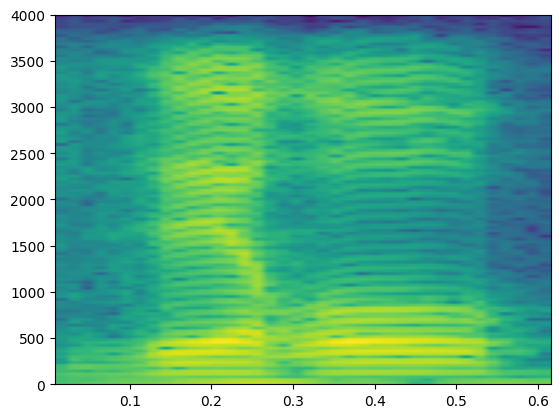

In [15]:
plt.specgram(wav_data, Fs=sample_rate)
plt.show()

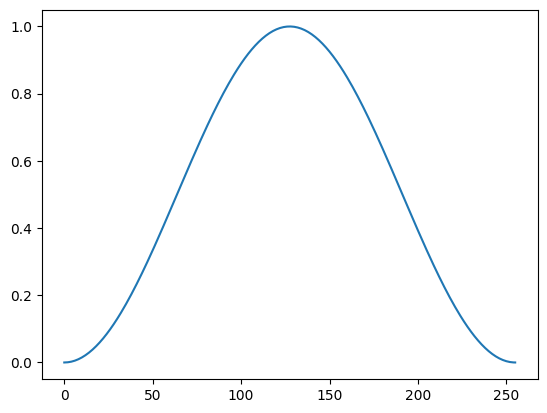

In [16]:
plt.plot(np.hanning(256))

## Speech Feature Extraction

Write a python function ```feature_extraction``` to calculate the cepstral parameterization associated with each pronunciation. With regard to the parameters of the analysis, we will make the following choices: 
- **Parameterization type**: Cepstrum (real number) using linear frequency scale (as opposed to Mel-frequency cepstrum) and computed using FFT (Fast Fourier Transform)
- **Weigthing window**: Hanning

The inputs of the function will be the following:
- **Wav data**: The data extracted from a .wav file
- **Window size**: 256 samples (32 ms)
- **Window shift**: 128 samples
- **Cepstral order**: p = 10


For each signal, the result of the analysis is a sequence of parameters that will be stored in a matrix
according to the following convention:

$$ \quad X = \underbrace{\left[\begin{array}{c} 
 X_1 \\
 X_2 \\
 \vdots \\
 X_{l_X}
\end{array} \right]}_p  $$

Each $X_i$ is a line vector of size $p$. Note that the number of ceptral vectors obtained ($l_X$) depends on the length of the signal, so it is variable. We obtain one matrix of this type per signal.

In [42]:
def feature_extraction(wav_data, window_size, window_shift, cepstral_order):
    #
    # Indication: use the numpy functions np.hanning, np.fft.fft, and np.fft.ifft.
    # Use the attribute .real to take the real part of complex numbers that are output by np.fft.ifft
    # Don't hesitate to look at the numpy documentation to get a better understanding of what the functions do !
    
    window = np.hanning(window_size)
    num_samples = len(wav_data)
    tab_cepstral_vectors = []
    i = 0
    
    while(i + window_size < len(wav_data)):
        frame = wav_data[i:i+window_size]
        windowed_frame = frame * window
        cepstral_vectors = np.fft.ifft(np.log(np.abs(np.fft.fft(windowed_frame)))).real
        
        tab_cepstral_vectors.append(cepstral_vectors[:cepstral_order])
        i += window_shift
    
    return np.array(tab_cepstral_vectors)

In [43]:
# Example !
window_size = 256
window_shift = 128
cepstral_order = 10
cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)

In [39]:
5098 // 128 - 1

38

In [46]:
print("Shape of cepstral matrix:", [len(cepstral_vectors), len(cepstral_vectors[0])])

Shape of cepstral matrix: [38, 10]


## Time Alignment by Dynamic Programming

Write a python function ```time_alignment(x, y, gamma)``` performing time alignment by dynamic programming between two sequences of vectors stored with the convention above. The Euclidean norm between the following vectors and time
constraints will be used:

\begin{matrix}
  \bullet & \rightarrow & \bullet\\
   & \nearrow_{\gamma} & \uparrow\\
  \bullet & & \bullet
\end{matrix}

with a diagonal weighting $\gamma$ that may be chosen different from 1. It is essential to carry out this function in a parameterized way in order to be able to validate it on the mono-dimensional example being studied.
The function will take as **inputs** the two vector sequences $(X_1, \dots, X_{l_X})$ et $(Y_1, \dots, Y_{l_Y})$ stored in the two matrices, as well as the parameter $\gamma$. It will then execute the following operations:
- **Calculation of the similarity matrix**: Given the two vector sequences, calculate the matrix $C (l_X \times l_Y)$ such that $C(i,j) = \|X_i-Y_j\|$.
- **Initialization of the cumulative distance matrix**: Calculate the content of the first row and column of the cumulative distance matrix $D (l_X \times l_Y)$ such that $D(i,j)$ contains the cumulative distance along the minimum cumulative distance path joining the node $(i,j)$ at the initial node $(1,1)$.
- **Calculation of the matrix of cumulative distances**: For $i$ ranging from 2 to $\min(l_X,l_Y)$, calculation of $D(i,i)$ then $D(i+1,i), \dots D(l_X,i)$ and $D(i,i+1), D(i,i+2), \dots D(i,l_Y)$ (you will recall what justifies this way to proceed). To store the predecessor along the optimal path leading to $(i,j)$, you can use a three-dimensional array $B (l_X \times l_Y \times 2)$ since the predecessor is a node of the network defined by its two coordinates (we can alternatively use a "code" representing the three possible predecessors).
- ***Bactracking***: From the node $(l_X,l_Y)$, reconstruction of the optimal path (starting from the end).

Finally, the **output** will be the cumulative distance along the path of least cost  (```distance```) and the alignment path (```M```), in the form of the matrix  $M$  with two columns such that $X_{M(i,1)}$  is the vector mapped to $Y_{M(i,2)}$ (note that the number of lines in this matrix corresponding to the length of the optimal path is variable). The function can also return the matrix of cumulative distances (```D```).

In [154]:
from scipy.spatial.distance import cdist

def time_alignment(x, y, gamma):
    # Calculation of the similarity matrix
    G = cdist(x,y)
    # matrix of Cumulative distances
    D = np.zeros((len(x), len(y)))
    M = np.zeros((len(x), len(y)))
    D[0][0] = 0
    M[0][0] = 0
    for i in range (1, len(x)):
        D[i][0] = D[i-1][0] + G[i][0]
        M[i][0] = 2
    
    for j in range(1,len(y)):
        D[0][j] = G[0][j] + D[0][j-1]
        M[0][j] = 1


    
    for i in range (1, len(x)):
        for j in range(1,len(y)):
            tab = [D[i-1][j-1] + gamma * G[i][j], D[i][j-1] + G[i][j], D[i-1][j] + G[i][j]]
            nb = np.argmin(tab)
            D[i][j] = tab[nb]
            M[i][j] = nb

    i = len(x) - 1
    j = len (y) - 1
    distance = 0
    lis = []
    while (i,j) != (0,0):
        if (M[i][j] == 0):
            distance += 2
            i -= 1
            j -= 1
            lis += [(i,j)]
            
        elif (M[i][j] == 1):
            distance += 1
            j -= 1
            lis += [(i,j)]
        else :
            distance =+ 1
            i -= 1
            lis += [(i,j)]
            
    return D, lis, D[-1][-1]/distance

In [109]:
x_ex= np.array([2, 3, 4, 5, 6, 7])
y_ex = np.array([1, 2, 2, 4, 6])
cdist((x_ex,),(y_ex,))

ValueError: XA and XB must have the same number of columns (i.e. feature dimension.)

In [155]:
# Example of time alignment
file_path_1 = "./Data/SIG/SIG_Rep_1_Number_0.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
file_path_2 = "./Data/SIG/SIG_Rep_2_Number_0.wav"
sample_rate_2, wav_data_2 = wavfile.read(file_path_2)
cepstral_vectors_1 = feature_extraction(
wav_data_1, window_size, window_shift, cepstral_order)
cepstral_vectors_2 = feature_extraction(
wav_data_2, window_size, window_shift, cepstral_order)

np.set_printoptions(precision=4)
D, M, distance = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=2)

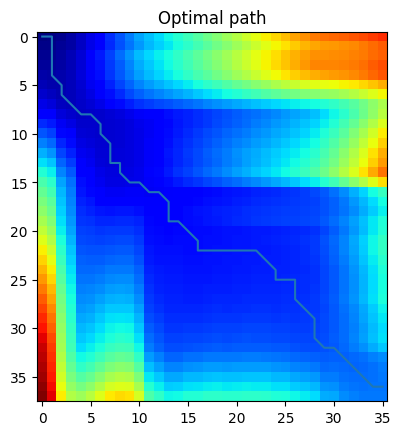

Cost of the optimal path: 11.715516662697539


In [156]:
# Example of visualization of the optimal path
M = np.array(M)
plt.imshow(D, cmap='jet')
plt.title("Optimal path")
plt.plot(M[:,1], M[:,0])
plt.show()
print("Cost of the optimal path:", distance)

### Applications to Speech Data

First, working on the data from ```SIG```, you will align a reference sequence (for example, the one corresponding to the first repetition of the first word) with all the others. If we try to find, among all numbers of a given repetition (from 1 to 12), which is the same one as the reference, by looking at the closest in terms of distance (of the path of least cost):
1. Are the performances satisfactory ?
2. What is the influence of the γ choice (weighting of the diagonal path) on the alignment paths (in order to answer, examine characteristic cases and try to judge the relevance of the alignment paths by visualizing them) ? Does this parameter have a significant influence on the obtained distance?
3. What implicit hypothesis is made when using the Euclidean distance to measure the proximity of ceptral vectors? Does this hypothesis seem acceptable to you in view of the differences between aligned sequences corresponding to different repetitions of the same word? Propose (it is not necessary to implement it!) a method to estimate from the aligned data an appropriate weighting for the comparison of ceptral vectors. Do you think this weighting could improve discrimination performance?

### 1

In [168]:
file_path_1 = "./Data/SIG/SIG_Rep_1_Number_2.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)


for j in range(2, 13):
    min_path = -1
    min_file = ""
    for i in range(10):
        file_path = f"./Data/SIG/SIG_Rep_{j}_Number_{i}.wav"
        sample_rate_2, wav_data_2 = wavfile.read(file_path)
        cepstral_vectors_1 = feature_extraction(wav_data_1, window_size, window_shift, cepstral_order)
        cepstral_vectors_2 = feature_extraction(wav_data_2, window_size, window_shift, cepstral_order)

        np.set_printoptions(precision=4)
        D, M, distance = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=2)

        if min_path < 0 or min_path > distance:
            min_path = distance
            min_file = file_path
    print(min_file)


./Data/SIG/SIG_Rep_2_Number_5.wav
./Data/SIG/SIG_Rep_3_Number_9.wav
./Data/SIG/SIG_Rep_4_Number_9.wav
./Data/SIG/SIG_Rep_5_Number_2.wav
./Data/SIG/SIG_Rep_6_Number_2.wav
./Data/SIG/SIG_Rep_7_Number_2.wav
./Data/SIG/SIG_Rep_8_Number_2.wav
./Data/SIG/SIG_Rep_9_Number_2.wav
./Data/SIG/SIG_Rep_10_Number_9.wav
./Data/SIG/SIG_Rep_11_Number_9.wav
./Data/SIG/SIG_Rep_12_Number_4.wav


The performance is fine, not exeptional, but it can reconise the right number most of the time.

### 2

The parameter gamma influences on the path that will be taken. For instance if we take a gamma smaller that 2, it will be very interesting to travel through the diagonale (as for equal weights costs less than the vertical + horizontal path. gamma*w < 2*w = 1*w + 1*w). Otherwise, if gamma is greater than 2, our optimal Path will more likely be a stair (as it wants to avoid the diagonal that costs more than taking the sides of the triangle.). In fact 2 is the limit that for equal weights, consider the diagonale as as costly as th evertical and horizontal (stair alike) path.

### 3

The euclidiean distance involve the difference between the coordinate squared, which means that not having the same amplitude between the two signals, or having a sall time difference will impact the distance a lot. A way to better compare the two signals may be to compute statistical values between the two signals, like the mean, the variance, ... in order to avoid to value a difference in amplitude too much. Or we can try to use the norm 1.

## Evaluation of Speech Recognition

The goal of this part is to implement an evaluation strategy in order to check how well our method can be used for speech recognition, especially when we generalize to more than one speaker. 
We will separate the available signals into a *reference* and *unknown* set, and label all the unknow signals by finding the signal in the reference set they are the closest to (in terms of cost of the optimal path given by ```time_alignement```. Ideally, we would need to rotate the reference/unknown sets to perform cross-validation - but we can work with a random choice of only one reference for each number to simplify the setup. 
To do so, write a function ```classification```. For example, you can use the following formalism : 

```[confusion, accuracy] = classification(vectors, gamma)```

- ```vectors``` contains all the cepstral vectors for the signals in the chosen dataset. It can be under the form of a list of matrices, being the outputs of ```feature_extraction``` for all signals. If $N$ if the number of repetetitions, ```vectors``` contains $10N$ matrices.
- ```gamma``` is the parameter $\gamma$ of the alignment.


- ```confusion``` is the confusion matrix of size $10 \times 10$.
- ```accuracy``` is the recognition rate (averaged over cross-validation experiments if used).

In [189]:
def time_alignment_tab(vecs, vec2, gamma):
    min_path = -1
    best_nb = -1
    tab = np.zeros(10)
    for i in range(10):
        _, _, distance = time_alignment(vecs[i], vec2, gamma)
        tab[i] = distance
        
        if min_path < 0 or min_path > distance:
            min_path = distance
            best_nb = i
    
    return best_nb, tab

In [192]:
def classification(vectors, gamma):
    N = 12
    confusion = np.zeros((10, 10))
    correct_predictions = 0
    for i in range(N, len(vectors)):
        predicted_class, _ = time_alignment_tab(vectors[:10], vectors[i], gamma)
        true_class = i % 10
        confusion[true_class][predicted_class] += 1
        
        if predicted_class == true_class:
            correct_predictions += 1

    accuracy = correct_predictions / (len(vectors) - N)
    
    return [confusion, accuracy]
    

Questions: 
- Evaluate the speech recognition performance on the data ```SIG```, and then on the data ```SIG2```. Visualize the confusion matrices ? 
- Evaluate the generalization capabilities to other speakers using protocol 3 on ```SIG_MIXED```. Try to interpret the results.
- What are the limitations of dynamic time warping approaches for speech recognition that you have identified during this lab ? Propose (shortly) possible solutions to these problems.

In [197]:
# Step 1: Prepare the data and extract cepstral vectors for SIG dataset
sig_data = "./Data/SIG/"
num_repetitions = 12
num_numbers = 10
gamma = 2

vectors_sig = []
for i in range(num_repetitions):
    for j in range(num_numbers):
        file_path = sig_data + f"SIG_Rep_{i+1}_Number_{j}.wav"
        sample_rate, wav_data = wavfile.read(file_path)
        cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)
        vectors_sig.append(cepstral_vectors)

# Step 2: Evaluate speech recognition performance and visualize confusion matrix for SIG dataset
confusion_sig, accuracy_sig = classification(vectors_sig, gamma)
print("Accuracy (SIG):", accuracy_sig)
print("Confusion Matrix (SIG):")
print(confusion_sig)

# Step 1: Prepare the data and extract cepstral vectors for SIG2 dataset
sig_data = "./Data/SIG2/"
num_repetitions = 6
num_numbers = 10
gamma = 2

vectors_sig2 = []
for i in range(num_repetitions):
    for j in range(num_numbers):
        file_path = sig_data + f"SIG2_Rep_{i+1}_Number_{j}.wav"
        sample_rate, wav_data = wavfile.read(file_path)
        cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)
        vectors_sig2.append(cepstral_vectors)

# Step 2: Evaluate speech recognition performance and visualize confusion matrix for SIG dataset
confusion_sig2, accuracy_sig2 = classification(vectors_sig2, gamma)
print("Accuracy (SIG):", accuracy_sig2)
print("Confusion Matrix (SIG):")
print(confusion_sig2)

Accuracy (SIG): 0.32407407407407407
Confusion Matrix (SIG):
[[0. 0. 3. 0. 0. 0. 0. 7. 0. 0.]
 [0. 5. 2. 0. 0. 0. 0. 3. 0. 0.]
 [0. 2. 7. 0. 0. 0. 0. 1. 0. 1.]
 [0. 6. 2. 1. 0. 0. 0. 1. 0. 1.]
 [0. 1. 4. 0. 4. 0. 0. 2. 0. 0.]
 [0. 2. 1. 0. 0. 6. 0. 1. 0. 1.]
 [0. 0. 3. 0. 0. 0. 1. 7. 0. 0.]
 [0. 0. 5. 0. 0. 1. 0. 5. 0. 0.]
 [0. 0. 5. 0. 0. 0. 0. 4. 1. 1.]
 [0. 0. 5. 0. 0. 0. 0. 1. 0. 5.]]
Accuracy (SIG): 0.375
Confusion Matrix (SIG):
[[0. 0. 3. 0. 0. 0. 0. 1. 0. 0.]
 [0. 2. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 3. 0. 0. 0. 0. 1. 0. 0.]
 [0. 3. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 3. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 4. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 4. 0. 0.]
 [0. 0. 3. 0. 0. 0. 0. 2. 0. 0.]
 [0. 0. 3. 0. 0. 0. 0. 2. 0. 0.]
 [0. 0. 2. 0. 0. 0. 0. 0. 0. 3.]]


### 2

In [202]:
# Step 1: Prepare the data and extract cepstral vectors for SIGMIX dataset
sig_mixed_data = "./Data/SIGMIX/"
num_repetitions = 12
num_numbers = 10
gamma = 2

vectors_sig_mixed = []
for i in range(num_repetitions):
    for j in range(num_numbers):
        file_path = sig_mixed_data + f"SIGMIX_Rep_{i+1}_Number_{j}.wav"
        sample_rate, wav_data = wavfile.read(file_path)
        cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)
        vectors_sig_mixed.append(cepstral_vectors)

# Step 2: Evaluate speech recognition performance and visualize confusion matrix for SIGMIX dataset
confusion_sig_mixed, accuracy_sig_mixed = classification(vectors_sig_mixed, gamma)
print("Accuracy (SIGMIX):", accuracy_sig_mixed)
print("Confusion Matrix (SIGMIX):")
print(confusion_sig_mixed)


Accuracy (SIGMIX): 0.2777777777777778
Confusion Matrix (SIGMIX):
[[0. 4. 4. 0. 0. 0. 0. 1. 0. 1.]
 [0. 5. 2. 0. 0. 0. 0. 3. 0. 0.]
 [0. 5. 4. 0. 0. 0. 0. 2. 0. 0.]
 [0. 3. 1. 7. 0. 0. 0. 0. 0. 0.]
 [0. 4. 3. 0. 3. 0. 0. 1. 0. 0.]
 [0. 2. 2. 0. 0. 4. 0. 3. 0. 0.]
 [0. 0. 6. 0. 0. 0. 0. 5. 0. 0.]
 [0. 3. 3. 0. 0. 0. 0. 3. 0. 2.]
 [0. 0. 3. 3. 0. 0. 0. 4. 0. 1.]
 [0. 2. 4. 0. 0. 0. 0. 1. 0. 4.]]


The accuracy is good, even better than for the other SIG, we may explain that thanks the increased diversity in the Rep, which means that there is less overfitting, and we adapt better to changes in the way the number is said.

### 3

We realised that the zero is often read as an eight (no number is considered as a zero). This may be due to the legth of the zero (the zero files are larger than the others hence the signal may be longer). As a result the total weight is bigger if there is a zero in the comparison and this may generates errors in the result.